In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [17]:
import metric_learn

In [18]:
%pylab inline
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

Populating the interactive namespace from numpy and matplotlib


Log scale is much better.
Total time is 722s
EP time near 510s is evident, remainder of time is what is known as overetch.  This portion determines the etched feature profile and final CD.  We may consider using log_df when performing data analysis later.


### Having looked at the data file for shape and conventions used in the files, we now need to get all the training data from csv files 

In [84]:
'''
need to scroll through my training data and open the csv files into a df.  will store this is a dict of key:value pairs
key = string filename that includes the IMOxxxxxx identifier which will be used to match to 'Error' value 
value = dataframe made up of the csv file data 
'''
import glob
import pprint

top_dataLists = {}                                                      #initialize our dict to be filled w df's from csv files

for datafile in sorted(glob.glob(r"\\Imoshare010\dryetch$\TetraX_DET07_EyeD\OES_csv_spectra_A\*spectra_A_IMO*")):   #use glob to aggregate files/folders into our dict
    '''perform the column indexing and transposing to get each df in correct format.'''
    df = pd.read_csv(datafile)  
    df.rename(columns ={'Run Time':'Time'}, inplace = True)
    df = df.drop('Name', 1)
    df.set_index('Time', inplace = True)
    df.columns.name = 'Wavelength'
    
    '''Need to match the Label categorization for the lots'''
    
    
    
    
    '''End matching'''
    id = str(re.findall('(?<=_A_)[A-Z0-9]+', datafile))
    df = df.iloc[0:350]                                       #will need arrays of all same length so use only the first 350 rows
    top_dataLists[id] = df                                        #populate dict values with each raw csv file of interest
    #dataLists[id] = log(df)                                   #populate dict values with log value csv
    
    
    print('datafiles loaded:',datafile)
    #pprint.pprint (glob.glob("Critical_KMONs/*spectra_A*"))        #checking files pulled for debug

#dataLists                                                          #check it if needed for debug
print('Last file opened:',datafile)                                                     #print last filename opened
df.head()                                                           #show the last dataframe loaded into dict

datafiles loaded: \\Imoshare010\dryetch$\TetraX_DET07_EyeD\OES_csv_spectra_A\2017-01-03-14-33-19_DET7AEP01_PodA_CHA_KMON_Step0_spectra_A_IMO294852.csv
datafiles loaded: \\Imoshare010\dryetch$\TetraX_DET07_EyeD\OES_csv_spectra_A\2017-01-08-17-44-47_DET7AEP01_PodA_CHA_KMON_Step0_spectra_A_IMO305019.csv
datafiles loaded: \\Imoshare010\dryetch$\TetraX_DET07_EyeD\OES_csv_spectra_A\2017-01-11-13-44-05_DET7AEP01_PodB_CHA_KMON_Step0_spectra_A_IMO308131.csv
datafiles loaded: \\Imoshare010\dryetch$\TetraX_DET07_EyeD\OES_csv_spectra_A\2017-01-11-17-18-23_DET7AKMON_PodA_CHA_KMON_Step0_spectra_A_IMO308056.csv
datafiles loaded: \\Imoshare010\dryetch$\TetraX_DET07_EyeD\OES_csv_spectra_A\2017-01-11-23-36-27_DET7AEP01_PodA_CHA_KMON_Step0_spectra_A_IMO306885.csv
datafiles loaded: \\Imoshare010\dryetch$\TetraX_DET07_EyeD\OES_csv_spectra_A\2017-01-13-13-46-51_DET7AEP02_PodB_CHA_KMON_Step0_spectra_A_IMO308310.csv
datafiles loaded: \\Imoshare010\dryetch$\TetraX_DET07_EyeD\OES_csv_spectra_A\2017-01-13-20-31-

Wavelength,200.0,200.5,201.0,201.5,202.0,202.5,203.0,203.5,204.0,204.5,...,795.5,796.0,796.5,797.0,797.5,798.0,798.5,799.0,799.5,800.0
Time,,,,,,,,,,,,,,,,,,,,,
2.0,736,728,720,710,704,699,694,693,693,691,...,876,834,910,1307,1571,1416,956,879,1099,1090
4.0,917,890,864,839,820,803,795,788,782,776,...,1259,1142,1347,2415,3135,2717,1463,1278,1861,1828
6.0,1045,1003,965,928,898,877,860,847,838,830,...,1262,1148,1358,2390,3081,2674,1462,1281,1844,1812
8.0,1053,1010,970,931,902,880,862,849,839,830,...,1251,1142,1342,2346,3019,2625,1451,1269,1810,1778
10.0,1052,1008,967,930,905,878,860,849,838,828,...,1249,1143,1334,2325,2993,2607,1448,1264,1791,1763


In [85]:
#we can see the number of data points available that have spectra <- not all of these will have an 'Error' value but all 
#runs with an 'Error' should be found.  Verify later in code.
dataLists = top_dataLists 
print (len(top_dataLists))

170


### The above sequence of code has loaded all of the datasets into a dictionary of dataframes that each represents a run of data that will be labeled according to the corresponding Error for that lot.

In [97]:
#this cell will randomly select 10 runs from the list of runs in dataLists and create a simulated test case for initial model 
#validations.  The 10 anomalous runs will mimic a short 30s plasma instability by perturbation of the 

import random

#function to generate random perturbation start and length
def Perturbation():
    times = []
    
    t = random.randint(10,60)            #generate a random length of simulated instability
    times = [0]*t
    tstart = 2*random.randint(100, 300)  #generate a random even start time for the simulated instability between 200-550
    
    j = 0
    while j < len(times):                #geneate list of times that will be altered 
        if j == 0: times[j] = tstart
        else: times[j] = times[j-1] + 2  #every 2 seconds per the df index of datafiles
        j +=1

    return times

#randomly select 10 runs for perturbation
outliers = random.sample(list(dataLists), 10)
print (outliers)

#create dataframe of the lot ID which will be labeled as 1|0
labels = []
for k,v in dataLists.items():
    labels.append(k)
labels_df = pd.DataFrame(labels)
labels_df.columns = ['ID']
labels_df['Label'] = ''
labels_df.set_index('ID', inplace = True)

'''
Wavelengths that pertain to this domain that would simulate a perturbation or a real species
Cl2 = 254.4, 256.1
O2+ = 258.1
'''

#sort through runs for selected outlier matches and genrate the perturbation in the data file
for k in dataLists:
    if k in outliers:
        labels_df.at[k,'Label'] = 1
        outlier_df = dataLists[k]
        timeslist = Perturbation()

        #cycle through time row in times list and change the output signal to simulate instability
        cnt = 0
        for i in timeslist:                         
            if cnt < len(timeslist)/2: 
                decay = cnt
                cnt +=1
                outlier_df.at[i, '254.0'] = outlier_df.ix[i, '254.0'] + 500*decay
                outlier_df.at[i, '254.5'] = outlier_df.ix[i, '254.5'] + 500*decay
                outlier_df.at[i, '255.0'] = outlier_df.ix[i, '255.0'] + 500*decay
                outlier_df.at[i, '255.5'] = outlier_df.ix[i, '255.5'] + 500*decay
                outlier_df.at[i, '256.0'] = outlier_df.ix[i, '256.0'] + 500*decay
                outlier_df.at[i, '256.5'] = outlier_df.ix[i, '256.5'] + 500*decay
                outlier_df.at[i, '257.0'] = outlier_df.ix[i, '257.0'] + 500*decay
                outlier_df.at[i, '257.5'] = outlier_df.ix[i, '257.5'] + 500*decay
                outlier_df.at[i, '258.0'] = outlier_df.ix[i, '258.0'] + 500*decay
            else:
                decay = decay - 1
                outlier_df.at[i, '254.0'] = outlier_df.ix[i, '254.0'] + 500*decay
                outlier_df.at[i, '254.5'] = outlier_df.ix[i, '254.5'] + 500*decay
                outlier_df.at[i, '255.0'] = outlier_df.ix[i, '255.0'] + 500*decay
                outlier_df.at[i, '255.5'] = outlier_df.ix[i, '255.5'] + 500*decay
                outlier_df.at[i, '256.0'] = outlier_df.ix[i, '256.0'] + 500*decay
                outlier_df.at[i, '256.5'] = outlier_df.ix[i, '256.5'] + 500*decay
                outlier_df.at[i, '257.0'] = outlier_df.ix[i, '257.0'] + 500*decay
                outlier_df.at[i, '257.5'] = outlier_df.ix[i, '257.5'] + 500*decay
                outlier_df.at[i, '258.0'] = outlier_df.ix[i, '258.0'] + 500*decay          
        dataLists[k] = outlier_df.dropna()              #reassign the new outlier peak dataframe back to dataLists
        some_spectra = outlier_df        
    else: labels_df.at[k,'Label'] = 0                   #label lots not changed as normal
labels_df.loc[labels_df['Label'] == 1]  

dataLists_sim = {}
matchcounter = 0
missingcounter = 0
for k in dataLists:
    if k in labels_df.index:
        category = labels_df.at[k,'Label']
        #print (k, category)
        dataLists_sim[k] = (category, dataLists[k])
        matchcounter +=1
        #if category == 1: print(k,'\n',dataLists2[k])   #validation line for checking all the outliers
    else: 
        '''Lot not in dataLists'''
        missingcounter += 1
        continue

y_simtest = {} # our simulation labels
X_simtest = {} # our simulation spectra data
for k,(label, spectra) in dataLists_sim.items():
    y_simtest[k] = label
    X_simtest[k] = spectra
    last = k
print ('last key', k)
X_simtest[k].head()

["['IMO314770']", "['IMO318405C']", "['IMO303866']", "['IMO316978']", "['IMO319872A']", "['IMO309929A']", "['IMO311425']", "['IMO319434']", "['IMO306885']", "['IMO316832']"]
last key ['IMO319397']


Wavelength,200.0,200.5,201.0,201.5,202.0,202.5,203.0,203.5,204.0,204.5,...,795.5,796.0,796.5,797.0,797.5,798.0,798.5,799.0,799.5,800.0
Time,,,,,,,,,,,,,,,,,,,,,
2.0,736,728,720,710,704,699,694,693,693,691,...,876,834,910,1307,1571,1416,956,879,1099,1090
4.0,917,890,864,839,820,803,795,788,782,776,...,1259,1142,1347,2415,3135,2717,1463,1278,1861,1828
6.0,1045,1003,965,928,898,877,860,847,838,830,...,1262,1148,1358,2390,3081,2674,1462,1281,1844,1812
8.0,1053,1010,970,931,902,880,862,849,839,830,...,1251,1142,1342,2346,3019,2625,1451,1269,1810,1778
10.0,1052,1008,967,930,905,878,860,849,838,828,...,1249,1143,1334,2325,2993,2607,1448,1264,1791,1763


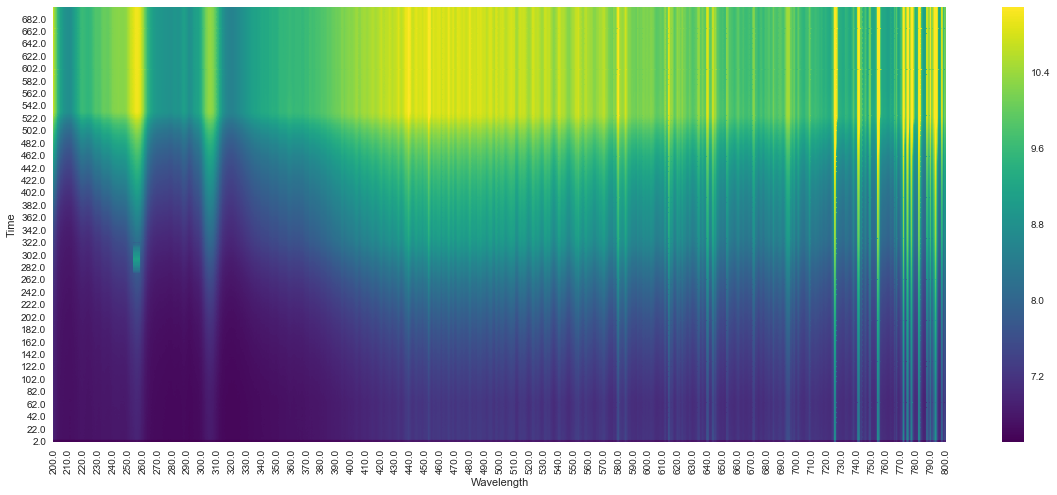

In [98]:
#heat map for new created anomylous samples
some_spectra_image = some_spectra
ax = sns.heatmap(log(some_spectra_image), xticklabels = 20, yticklabels = 10, cmap='viridis')
ax.invert_yaxis()         